# Predicting Category of an incident based on the information provided by the customer

### In this notebook, I am testing out to see if a basic classifier can do the job of classifying incidents reported to the campus computing department of UT Tyler 

#### Importing all the needed libraries

In [277]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import scipy as sc
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

#### Importing the data that is in cvs format

In [213]:
email_df = pd.read_csv("emails.csv", encoding='latin1')

#### Looking at the data

In [214]:
email_df.iloc[1:6]

,Subject,Body,From: (Name),From: (Address),From: (Type),To: (Name),To: (Address),To: (Type),CC: (Name),CC: (Address),CC: (Type),BCC: (Name),BCC: (Address),BCC: (Type),Billing Information,Categories,Importance,Mileage,Sensitivity
1,Preview of the May Agenda,Good morning! We would like to invite you to o...,Lynette Sutter,/O=UTTYLER ORGANIZATION/OU=EXCHANGE ADMINISTRA...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
2,CEP Dean Candidate Campus Wide Presentation/Go...,Please use the link below to access the Zoom r...,Beth Bruce,/O=UTTYLER ORGANIZATION/OU=EXCHANGE ADMINISTRA...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
3,CEP Dean Candidate Campus Wide Presentation/Ro...,Please use the link below to access the Zoom r...,Beth Bruce,/O=UTTYLER ORGANIZATION/OU=EXCHANGE ADMINISTRA...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
4,University Appreciation Week - A Few Reminders,Hello everyone!\r\n\r\n \r\n\r\nPlease see the...,usac,/O=UTTYLER ORGANIZATION/OU=EXCHANGE ADMINISTRA...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
5,Survey invitation: New survey on CCS Customer ...,You have been invited to take the survey: CCS ...,IT Support,/O=UTTYLER ORGANIZATION/OU=EXCHANGE ADMINISTRA...,EX,Ashim Sedhain,/o=UTTyler Organization/ou=Exchange Administra...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal


#### We can see that we get alot of data from the email. We will only use the subject and body of the email for the classification

#### Dropping columns all the columns besides the "Subject", and "Body".

In [215]:
email_df = email_df[["Subject", "Body"]]

#### Getting another look at the data now

In [216]:
email_df.head()

,Subject,Body
0,Your incident INC0121272 has been closed,Your incident INC0121272 has been closed. If y...
1,Preview of the May Agenda,Good morning! We would like to invite you to o...
2,CEP Dean Candidate Campus Wide Presentation/Go...,Please use the link below to access the Zoom r...
3,CEP Dean Candidate Campus Wide Presentation/Ro...,Please use the link below to access the Zoom r...
4,University Appreciation Week - A Few Reminders,Hello everyone!\r\n\r\n \r\n\r\nPlease see the...


# Cleaning the data 

#### Getting a closer look at the Body column

In [217]:
email_df.iloc[5, 1]

'You have been invited to take the survey: CCS Customer Satisfaction Survey. \r\n \r\nClick here to take your survey:\r\nhttps://uttyler.service-now.com/nav_to.do?uri=assessment_take2.do%3Fsysparm_assessable_type=4a9b211f2b0af10081807fb5a8da15d4%26sysparm_assessable_sysid=1afc56f5db5d73c8879ac3d239961920\r\n \r\nTo view your survey queue at any time, sign in and navigate to Self-Service > My Assessments & Surveys.\r\n \r\nRef:MSG1817995\r\n'

#### We can see the body has a lot of data which needs to be cleaned and parsed.

#### Whenever a ticket is submitted, the ticket contains the information about the person who submitted the ticket, subject and body. We will extract the category, which we are trying to predict, the body, and the subject.

#### Extracting the category from the Body text

In [218]:
email_df["Category"]= email_df["Body"].str.extract(r"Category: (\w+ ?\w+)\r")

#### Extracting Short Descriptions from the Body

In [219]:
email_df["Short Description"] = email_df["Body"].str.extract(r"Short Description: (.+)\r")

#### Extracting Additional comments from the Body text

In [220]:
email_df["Additional Comments"] = email_df["Body"].str.extract(r"Additional comments\r\nreceived from:(.+)Ref", flags = re.DOTALL)

#### Removing all the rows that do not have a Category and Short Description as these are emails that did not contain ticket related information

In [221]:
email_df.dropna(subset = ["Category", "Short Description"], inplace = True)

#### We will look at the shape to count the number of observation.

In [222]:
email_df.shape

(4806, 5)

#### We will look at the our dataframe.

In [223]:
email_df.head(1)

,Subject,Body,Category,Short Description,Additional Comments
6,Your incident INC0121272 has been resolved due...,Due to no customer response your incident INC0...,Account,Ashim Sedhain - credential pick up,NaN


#### We will need to drop emails not containing the phrase "We have moved your support ticket" as these are the only ones that have been categorized manually

In [224]:
filt = email_df["Body"].str.contains("We have moved your support ticket")
email_df.drop(email_df.loc[~filt].index, inplace = True)

#### A side note: There are dublicate tickets which will not be present in the final production and thus need to be removed from our sample

#### Extracting the incident number

In [225]:
email_df["Incident Number"] = email_df["Subject"].str.extract(r"INC(\d+) ")

#### We will only keep the short description and additional comments as this will only be the available data for us in production.

In [226]:
email_df.drop(["Subject", "Body"], axis = 1, inplace = True)

In [227]:
email_df.head()

,Category,Short Description,Additional Comments,Incident Number
41,Hardware,Engineering office moves,"KatrinaSmith@uttyler.edu\r\n \r\nMichael, \r...",0122904
42,Quotes,EVGA UV Plus - Multi-Screen expansion,rpeterson@uttyler.edu\r\n \r\nBefore I purcha...,0122638
44,Hardware,Printers,sbouis@uttyler.edu\r\n \r\nPlease help us dis...,0122888
46,Account,Access to previous compliance folders,NaN,0122872
47,Software,Adobe Flash Player installation,"TArtley@uttyler.edu\r\n \r\nGood Afternoon, \...",0122883


#### A closer look at additional comments

In [228]:
email_df["Additional Comments"].iloc[4]

' TArtley@uttyler.edu\r\n \r\nGood Afternoon, \r\n \r\nI need to have adobe flash player downloaded for firefox and when I try to do it the installation never starts. \r\n \r\nThanks,\r\n \r\nTyler Artley\r\nAssistant Director of Intramurals & Club Sports\r\n \r\n[http://www.uttyler.edu/]\r\n \r\nRecreational Sports\r\n3900 University Blvd.  ?  Tyler, Texas 75799\r\noffice  903.565.5571 \r\ntartley@uttyler.edu \r\n \r\nYour Success. Our Passion.\r\n \r\n'

#### We can see that the Additional Comments needs to be further cleaned.

#### We will replace all the new line characters and numbers

In [229]:
email_df["Additional Comments mod"] = email_df["Additional Comments"].str.replace(r"\r|\n|\d", "", regex = True)

In [230]:
email_df["Additional Comments mod"] = email_df["Additional Comments mod"].str.replace(r"\w+@\w+\.(edu)|(com)", "")

#### We will do the same for the short description

In [231]:
email_df["Short Description"] = email_df["Short Description"].str.replace(r"\r|\n|\d", "", regex = True)

In [232]:
email_df["Short Description"] = email_df["Short Description"].str.replace(r"\w+@\w+\.(edu)|(com)", "")

#### We will concatenate the Short Description and Additional Comments field to get the Feature which will be used for the final classification.

In [233]:
email_df["Feature"] = email_df["Short Description"].str.cat(email_df["Additional Comments mod"], sep = ' ')

In [234]:
email_df["Feature"].fillna(value = email_df["Short Description"], inplace = True)

In [235]:
print(f"Total number of unique emails: {email_df['Incident Number'].unique().size}")

Total number of unique emails: 2639


In [236]:
print(f"Total number of incidents: {email_df['Incident Number'].size}")

Total number of incidents: 2797


#### There seems to be dublicate incidents which need to be removed

## We will now look at our data and perfrom a simple data analysis

####  Lets look at the historgram of the lables

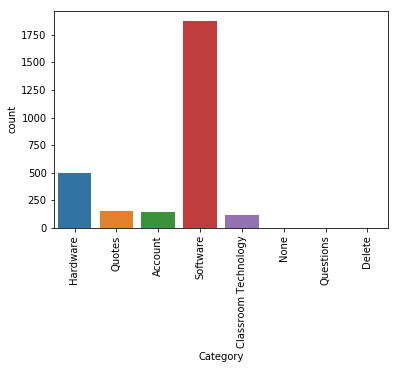

In [237]:
ax = sns.countplot("Category", data = email_df)
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

#### Seeing the ratio of each class

In [238]:
email_df["Category"].value_counts()#*100/email_df["Category"].size

Software                1873
Hardware                 502
Quotes                   150
Account                  144
Classroom Technology     120
Questions                  4
None                       2
Delete                     2
Name: Category, dtype: int64

#### We can see that the categories are heavly imbalanced. We will need to account for the imbalance.

### Let us look at the indivisual data points of the category with less than 4 samples

In [239]:
gp = email_df.groupby("Category")

In [240]:
gp.get_group("Questions")

,Category,Short Description,Additional Comments,Incident Number,Additional Comments mod,Feature
1476,Questions,Jooble partnership outlook.uttyler.edu,"rma@jooble.jobs\r\n \r\nHello,\r\n \r\nHope y...",0127614,"rma@jooble.jobs Hello, Hope you are doing wel...",Jooble partnership outlook.uttyler.edu rma@jo...
1594,Questions,Verification of student email on various apps,"DRoman@patriots.uttyler.edu\r\n \r\nDear IT,\...",0127977,"DRoman@patriots.uttyler.edu Dear IT, My name ...",Verification of student email on various apps ...
2801,Questions,Student Computers in Room,mizard@uttyler.edu\r\n \r\nCan you tell me if...,0133291,Can you tell me if the student puters have S...,Student Computers in Room Can you tell me i...
3760,Questions,"Read, Write and Goal",AshleyDavis@uttyler.edu\r\n \r\nGood afternoo...,0135744,"Good afternoon IT, The SAR office is purchas...","Read, Write and Goal Good afternoon IT, The ..."


In [241]:
gp.get_group("Delete")

,Category,Short Description,Additional Comments,Incident Number,Additional Comments mod,Feature
1902,Delete,DELETE,fjones@uttyler.edu\r\n \r\nTHIS EMAIL IS FOR ...,0129221,THIS EMAIL IS FOR THOSE WHO ARE INVOLVED IN ...,DELETE THIS EMAIL IS FOR THOSE WHO ARE INVOL...
3214,Delete,DELETE,adennis@uttyler.edu\r\n \r\nAvery Ritzma rece...,0134266,Avery Ritzma received the puter . When she ...,DELETE Avery Ritzma received the puter . Wh...


In [242]:
gp.get_group("None")

,Category,Short Description,Additional Comments,Incident Number,Additional Comments mod,Feature
743,None,Dakota-Request to borrow a monitor temporarily,NaN,0125169,NaN,Dakota-Request to borrow a monitor temporarily
1706,None,Ready for Delivery | Surface Pros for Mathemat...,NaN,0128505,NaN,Ready for Delivery | Surface Pros for Mathemat...


#### The sample of these categories are too few for the classifier to learn anything and thus will be removed from further analysis. Hand coded rules can be formed for these categories in the future

In [243]:
remove = ["Questions", "Delete", "None"]

In [244]:
for i in remove:
    email_df = email_df.loc[email_df["Category"]!=i]

In [245]:
email_df["Category"].unique()

array(['Hardware', 'Quotes', 'Account', 'Software',
       'Classroom Technology'], dtype=object)

#### Lets look at the length of all the tickets and see if we can use that as a feature.

In [246]:
email_df["Feature Length"] = email_df["Feature"].str.len()

In [247]:
gk = email_df.groupby("Category")
gk.mean()

,Feature Length
Category,
Account,325.215278
Classroom Technology,456.366667
Hardware,342.766932
Quotes,723.580000
Software,499.224773


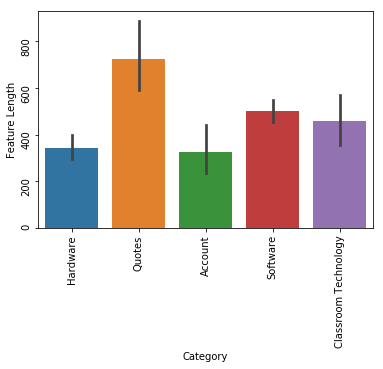

In [248]:
ax = sns.barplot(x = "Category", y = "Feature Length", data = email_df)
ax.tick_params(labelrotation=90)

#### We used length as a feature but there was not any significant results.

## Modeling

#### Converting the classes into numerical representation

In [249]:
dic = {i:j for i, j in zip(email_df["Category"].unique(), range(len(email_df["Category"].unique())))}

In [250]:
email_df["Targets"] = email_df["Category"].map(dic)

#### Looking at our data and seeing where we are.

In [251]:
email_df[["Feature", "Category","Targets"]].head()

,Feature,Category,Targets
41,"Engineering office moves Michael, WE have ...",Hardware,0
42,EVGA UV Plus - Multi-Screen expansion Before...,Quotes,1
44,Printers Please help us disconnect all desk...,Hardware,0
46,Access to previous pliance folders,Account,2
47,Adobe Flash Player installation Good Afterno...,Software,3


#### We will only be using the Feature column for our classification.

In [252]:
X = email_df["Feature"]
y = email_df["Targets"]

#### Spliting the data for training and testing

In [253]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [254]:
x_train.head()

2187    Reimage Computer-UC TAG Dell    Dell  TAG  UC ...
1877     Laptops need to be cleaned and given to stora...
3327    Access to Email   Hello, The system will not l...
5625    Adobe, P: Drive, and Visio Missing   Good morn...
4030    Dragon    I am  needing Dragon Dictate loaded ...
Name: Feature, dtype: object

#### Fitting the CountVectorizer to the training data

In [255]:
# vect = CountVectorizer(ngram_range= (1,2), stop_words = "english")
vect = TfidfVectorizer(ngram_range = (1, 3), stop_words = "english", min_df = 6)

In [256]:
vect = vect.fit(x_train)

#### We can see how many features we have.

In [257]:
len(vect.get_feature_names())

4126

#### Transforming our training data into a sparse matrix

In [258]:
x_train_vec = vect.transform(x_train)

In [259]:
x_train_vec

<2091x4126 sparse matrix of type '<class 'numpy.float64'>'
	with 90835 stored elements in Compressed Sparse Row format>

In [260]:
x_train_vec.shape

(2091, 4126)

## Classification

#### We will create multiple models and compare there performance.

#### Supervised Learning

In [261]:
logistic_clf = LogisticRegression(multi_class = "multinomial", solver = "lbfgs", random_state = 0, max_iter = 10000, C = 0.1)

In [262]:
naive_clf = MultinomialNB(alpha=0.1)

In [263]:
svm_clf = svm.SVC(gamma = 1, random_state = 0, kernel = "linear", max_iter = 10000)

In [264]:
knn_clf = KNeighborsClassifier(n_neighbors=30)

In [265]:
rf_clf = RandomForestClassifier(n_estimators=40, max_depth=6,random_state=0)

In [266]:
gb_clf = GradientBoostingClassifier(n_estimators = 25, max_depth = 5, random_state = 0)

In [267]:
clf = [logistic_clf, naive_clf, svm_clf, knn_clf, rf_clf, gb_clf]

clf_dic = ["Logistic", "Naive", "SVM", "KNN", "RandomForest", "GradientBoosting"]

In [268]:
for i in clf:
    i.fit(x_train_vec, y_train)
    print(".", end = "")

......

#### Looking at the f1 score of each classifier

In [269]:
x_test_vec = vect.transform(x_test)
for i,j in zip(clf_dic, clf):
#     print(f"{i} f1: {f1_score(j.predict(x_test_vec), y_test, average = 'weighted')}")
#     print(f"{i}: {precision_score(j.predict(x_test_vec), y_test, average = 'micro')}")
    print(f"{i} accuracy: {j.score(x_test_vec, y_test)}")

Logistic accuracy: 0.6876790830945558
Naive accuracy: 0.7607449856733525
SVM accuracy: 0.8123209169054442
KNN accuracy: 0.7134670487106017
RandomForest accuracy: 0.6747851002865329
GradientBoosting accuracy: 0.8080229226361032


#### We will look at the top features from each of the classifiers

In [270]:
def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        top10 =np.where(top10==feature_names.shape[0], feature_names.shape[0]-1, top10)
#         print(feature_names.shape[0])
        print("%s: %s" % (category, " ".join(feature_names[top10])))

In [271]:
show_top10(logistic_clf, vect, email_df["Category"].unique())

Hardware: xerox monitors scanner machine disposal uc monitor cas print printer
Quotes: tyler shi specs need quote pro dell hp order purchase quote
Account: log patriots issue pw email reset password employee change account
Software: docusign adobe login myuttyler error imagenow drive image outlook access
Classroom Technology: instructor smart zoom hpr hpc room sound classroom working projector


In [272]:
show_top10(naive_clf, vect, email_df["Category"].unique())

Hardware: uttyler cas new texas need tyler university puter office printer
Quotes: need www dell texas hp order university purchase tyler quote
Account: access log pw issue reset password email employee change account
Software: www need email uttyler edu university edu tyler puter uttyler access
Classroom Technology: cob tyler cas hpc hpr room sound classroom working projector


### We will ensemble the classifiers and see if that improves the results

In [273]:
clf = [naive_clf, svm_clf, knn_clf, gb_clf]

clf_dic = ["Naive", "SVM", "KNN", "GradientBoosting"]

In [279]:
estimators = list(zip(clf_dic, clf))

In [287]:
ensemble_clf = VotingClassifier(estimators, voting="hard")

In [288]:
ensemble_clf.fit(x_train_vec, y_train)

VotingClassifier(estimators=[('Naive', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)), ('SVM', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
  max_iter=10000, probability=False, random_state=0, shrinking=True,
  tol=0.001, v...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [289]:
ensemble_clf.score(x_test_vec, y_test)

0.8194842406876791

### We got an improvement of ~0.5

# Further Improvements